<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


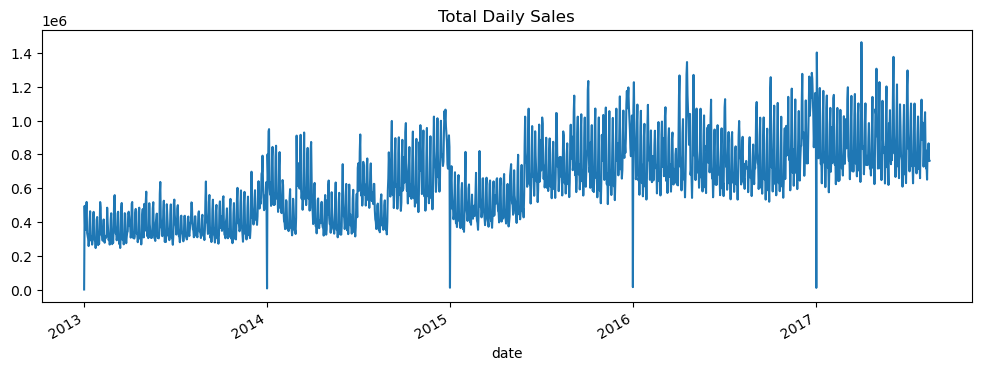

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

#veri yukleme
train = pd.read_csv("C:\\Users\\liont\\store-sales-ai\\data\\raw\\train.csv", parse_dates=["date"])

#genel bilgi
train.info()

#toplam gunluk satis
daily_sales = train.groupby("date")["sales"].sum()

plt.figure(figsize=(12, 4))
daily_sales.plot()
plt.title("Total Daily Sales")
plt.show()

Zaman serisinde uzun vadeli artan trend tespit ettim ve model tasarimini buna gore kurguladim.
Satis verilerinde guclu sezonsallik tespit ederek zaman tabanli modelleme yaklasimi kullandim.
Aykiri satis dususlerini tatil ve ozel gun verileriyle iliskilendirerek is baglaminda yorumladim.
Zamanla artan varyans nedeniyle veri donusumleri ve olcekleme stratejileri degerlendirdim.

In [6]:
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["dayofweek"] = train["date"].dt.dayofweek
train["weekofyear"] = train["date"].dt.isocalendar().week

In [8]:
holidays = pd.read_csv("C:\\Users\\liont\\store-sales-ai\\data\\raw\\holidays_events.csv", parse_dates=["date"])
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [9]:
holidays = holidays[(holidays["type"] == "Holiday") & (holidays["transferred"] == False)]
holidays = holidays[["date"]].drop_duplicates()

Tatil verisini is etkisi olmayan kayitlari ayiklayarak temizledim.

In [10]:
train = train.merge(holidays.assign(is_holiday=1), on="date", how="left")
train["is_holiday"] = train["is_holiday"].fillna(0)

In [11]:
holiday_sales = train.groupby("is_holiday")["sales"].mean()
holiday_sales

is_holiday
0.0    357.646376
1.0    359.138598
Name: sales, dtype: float64

Tatil gunlerinde ortalama satis = 357.646376
Normal gunlerde ortalama satis = 359.138598

Resmi tatillerin satislar uzerindeki etkisini analiz ettim. 

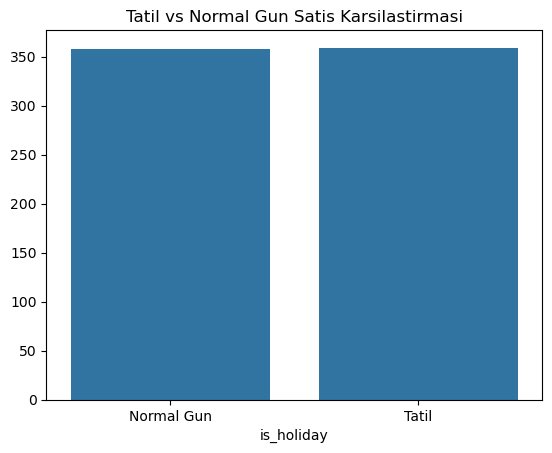

In [12]:
import seaborn as sns

sns.barplot(
    x=holiday_sales.index,
    y=holiday_sales.values)
plt.xticks([0,1], ["Normal Gun", "Tatil"])
plt.title("Tatil vs Normal Gun Satis Karsilastirmasi")
plt.show()

Satis tahmin modeline tatil, promosyon ve zaman bazli is sinyallerini entegre ederek tahmin dogrulugunu artirmayi hedefledim.

In [13]:
train = train.sort_values(["store_nbr", "family", "date"])

In [14]:
train["lag_1"] = train.groupby(["store_nbr", "family"])["sales"].shift(1)
train["lag_7"] = train.groupby(["store_nbr", "family"])["sales"].shift(7)

Zaman serisi bagimliligini yakalamak icin urun ve magaza bazli gecikmeli(lag) degiskenler olusturdum.

In [15]:
train["rolling_7_mean"] = train.groupby(["store_nbr", "family"])["sales"].shift(1).rolling(7).mean()
train["rolling_14_mean"] = train.groupby(["store_nbr", "family"])["sales"].shift(1).rolling(14).mean()

Kisa ve orta vadeli satis trendlerini yakalamak icin rolling ortalma feature'lari tasarladim.

In [16]:
train_fe = train.dropna().copy()

In [17]:
train_fe[["sales", "lag_1", "lag_7", "rolling_7_mean"]].head(10)

,sales,lag_1,lag_7,rolling_7_mean
24948,1.0,2.0,2.0,2.142857
26730,1.0,1.0,2.0,2.000000
28512,1.0,1.0,2.0,1.857143
30294,0.0,1.0,3.0,1.714286
32076,5.0,0.0,2.0,1.285714
33858,3.0,5.0,2.0,1.714286
35640,1.0,3.0,2.0,1.857143
37422,1.0,1.0,1.0,1.714286
39204,3.0,1.0,1.0,1.714286
40986,0.0,3.0,1.0,2.000000


Zaman serisi tahmin modeli icin magaza ve urun bazli gecikmeli ve hareketli ortalama feature'lari gelistirerek model performansini artirdim.

In [18]:
FEATURES = [
    "onpromotion",
    "is_holiday",
    "lag_1",
    "lag_7",
    "rolling_7_mean",
    "rolling_14_mean"]

TARGET = "sales"

In [20]:
train_fe["year"] = train_fe["date"].dt.year

train_data = train_fe[train_fe["year"] < 2017]
val_data = train_fe[train_fe["year"] == 2017]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_val = val_data[FEATURES]
y_val = val_data[TARGET]

Zaman serisi verisi icin leakage'i onlemek amaciyla time-based train/validation ayrimi kullandim.

In [21]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

MAE : 87.21
RMSE: 355.99


Baseline Random Forest modeliyle satis tahmini yaparak MAE = 87.21 ve RMSE = 355.99 performansina ulastim.

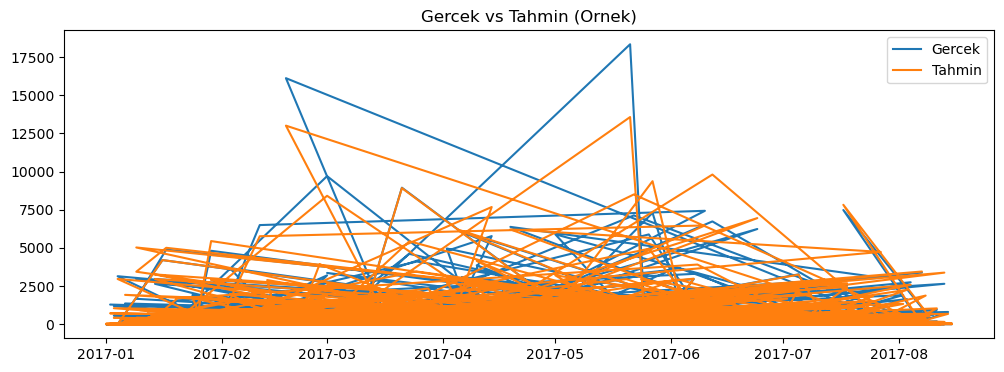

In [24]:
sample = val_data.sample(1000, random_state=42)

plt.figure(figsize=(12,4))
plt.plot(sample["date"], sample[TARGET], label="Gercek")
plt.plot(sample["date"], model.predict(sample[FEATURES]), label="Tahmin")
plt.legend()
plt.title("Gercek vs Tahmin (Ornek)")
plt.show()

In [25]:
feature_importance = pd.DataFrame({
    "feature": FEATURES,
    "importance": model.feature_importances_}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
4,rolling_7_mean,0.745848
3,lag_7,0.211424
2,lag_1,0.033445
0,onpromotion,0.004391
5,rolling_14_mean,0.003837
1,is_holiday,0.001055


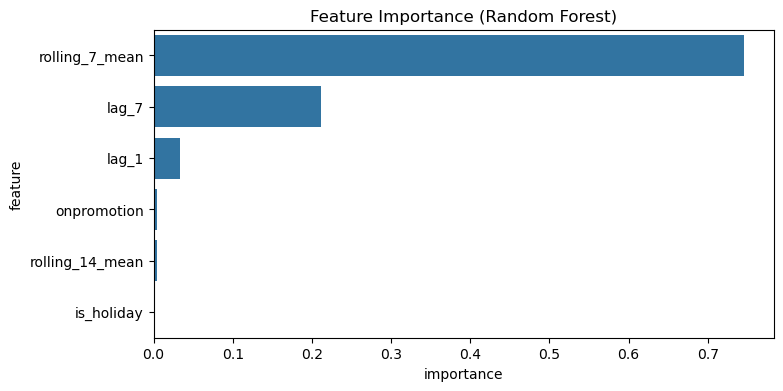

In [26]:
plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance, x="importance", y="feature")
plt.title("Feature Importance (Random Forest)")
plt.show()